In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from matplotlib import pyplot as plt

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [101]:
transform = T.Compose([
    T.ToTensor()
])

In [102]:
root = '/content'
train_set = datasets.FashionMNIST(
    root,
    train=True,
    transform=transform,
    download=True
)
test_set = datasets.FashionMNIST(
    root,
    train=False,
    transform=transform,
    download=True
)

In [103]:
batch_size = 128

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [104]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.net(x)

In [105]:
model_for_summary = LeNet().to(device)
summary(model_for_summary, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [106]:
input = torch.randn(1, 1, 28, 28).float().to(device)
out = model_for_summary(input)
print(out)

tensor([[-0.0565,  0.0374,  0.1071,  0.0458, -0.1743,  0.5568,  0.0828, -0.2892,
         -0.0739, -0.4841]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [107]:
def train_run_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [108]:
def test_run_epoch(model, device, test_loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            pred = output.argmax(1)
            correct += pred.eq(target).sum().item()

            total_loss += loss.item()

        accuracy = correct / len(test_set)
        avg_loss = total_loss / len(test_loader)

    return accuracy, avg_loss

In [109]:
def train(model, device, train_loder, test_loader, optimizer, criterion, num_epochs):
    train_avg_losses = []
    test_avg_losses = []
    accuracies = []

    for epoch in range(1, num_epochs+1):
        print(f"Epoch [{epoch}/{num_epochs}]")

        train_avg_loss = train_run_epoch(model, device, train_loader, optimizer, criterion)
        train_avg_losses.append(train_avg_loss)
        print(f"Average Train Loss = {train_avg_loss:.6f}")

        accuracy, test_avg_loss = test_run_epoch(model, device, test_loader)
        test_avg_losses.append(test_avg_loss)
        accuracies.append(accuracy)
        print(f"Average Test Loss = {test_avg_loss:.6f}")
        print(f"Test Accuracy = {accuracy:.2f}")
        print()

    return train_avg_losses, test_avg_losses, accuracies

In [110]:
num_epochs = 20
learning_rate = 1e-1

model_sgd = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_sgd.parameters(), lr=learning_rate)

In [111]:
sgd_train_losses, sgd_test_losses , sgd_accuracies = train(model_sgd, device, train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/20]
Average Train Loss = 2.307312
Average Test Loss = 2.307862
Test Accuracy = 0.10

Epoch [2/20]
Average Train Loss = 2.306767
Average Test Loss = 2.309882
Test Accuracy = 0.10

Epoch [3/20]
Average Train Loss = 2.306227
Average Test Loss = 2.309570
Test Accuracy = 0.10

Epoch [4/20]
Average Train Loss = 2.305675
Average Test Loss = 2.306133
Test Accuracy = 0.10

Epoch [5/20]
Average Train Loss = 2.305343
Average Test Loss = 2.305037
Test Accuracy = 0.10

Epoch [6/20]
Average Train Loss = 2.305614
Average Test Loss = 2.304873
Test Accuracy = 0.10

Epoch [7/20]
Average Train Loss = 2.305007
Average Test Loss = 2.305835
Test Accuracy = 0.10

Epoch [8/20]
Average Train Loss = 2.304746
Average Test Loss = 2.304082
Test Accuracy = 0.12

Epoch [9/20]
Average Train Loss = 2.304279
Average Test Loss = 2.305308
Test Accuracy = 0.10

Epoch [10/20]
Average Train Loss = 2.303867
Average Test Loss = 2.303022
Test Accuracy = 0.10

Epoch [11/20]
Average Train Loss = 2.302152
Average Test Lo

In [119]:
num_epochs = 20
learning_rate = 1e-2

model_adam = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_adam.parameters(), lr=learning_rate)

In [120]:
adam_train_losses, adam_test_losses, adam_accuracies = train(model_adam, device, train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/20]
Average Train Loss = 0.886971
Average Test Loss = 0.515378
Test Accuracy = 0.80

Epoch [2/20]
Average Train Loss = 0.440346
Average Test Loss = 0.398735
Test Accuracy = 0.85

Epoch [3/20]
Average Train Loss = 0.367098
Average Test Loss = 0.363251
Test Accuracy = 0.86

Epoch [4/20]
Average Train Loss = 0.327943
Average Test Loss = 0.344606
Test Accuracy = 0.87

Epoch [5/20]
Average Train Loss = 0.303558
Average Test Loss = 0.324076
Test Accuracy = 0.88

Epoch [6/20]
Average Train Loss = 0.288468
Average Test Loss = 0.322515
Test Accuracy = 0.88

Epoch [7/20]
Average Train Loss = 0.269722
Average Test Loss = 0.303651
Test Accuracy = 0.89

Epoch [8/20]
Average Train Loss = 0.256182
Average Test Loss = 0.317726
Test Accuracy = 0.88

Epoch [9/20]
Average Train Loss = 0.243653
Average Test Loss = 0.288631
Test Accuracy = 0.89

Epoch [10/20]
Average Train Loss = 0.233485
Average Test Loss = 0.284054
Test Accuracy = 0.90

Epoch [11/20]
Average Train Loss = 0.225034
Average Test Lo

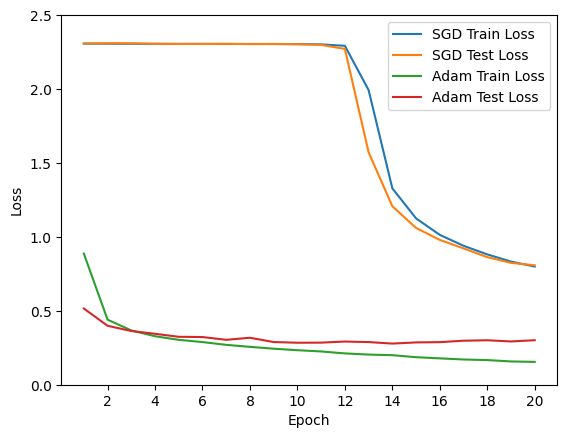

In [133]:
X = range(1, num_epochs+1)
plt.plot(X, sgd_train_losses, label="SGD Train Loss")
plt.plot(X, sgd_test_losses, label="SGD Test Loss")
plt.plot(X, adam_train_losses, label="Adam Train Loss")
plt.plot(X, adam_test_losses, label="Adam Test Loss")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

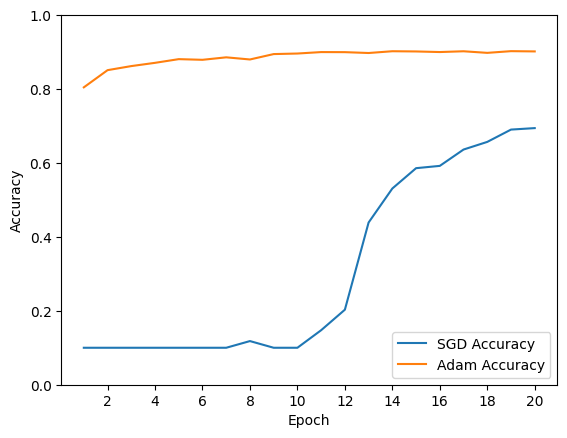

In [135]:
plt.plot(X, sgd_accuracies, label="SGD Accuracy")
plt.plot(X, adam_accuracies, label="Adam Accuracy")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()